In [1]:
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from scipy import stats
from random import randint, seed
import pandas as pd
import numpy as np
import eif

# Isolation Forests

Isolation forests are a method for *anomaly detection*, rather than classification in the usual sense - they specifically deal with the case where we need to split data into normal and anomalous categories. Fortunately, this is precisely the case which we are interested in here! The algorithm works as follows, with parameters $\varphi$ (the subsampling size) and $t$ (the ensemble size) and data $X$:

* Training stage:
    1. We sample $\varphi$ points from $X$, uniformly without replacement. Let this be $X'$.
    2. We now construct an isolation tree from $X'$ as follows:
        1. Set the maximum tree depth $l$ as $l = ceil(log_2\varphi)$
        2. Choose a partition of $X'$ uniformly at random, excluding those which contain only one data point and those which are already at the maximum depth.
        3. Choose a feature $q$ at random. Let $q_{min}$ and $q_{max}$ be the minimum and maximum values of $q$ among data points in $X'$.
        4. Choose a split point $p$ (at random) which satisfies $q_{min} < p \leq q_{max}$.
        5. Split $X'$ into two new partitions, one with $q < p$ and the other with $q \geq p$.
        6. Repeat this process until there are no more eligible partitions - every point has either been isolated or is at the maximum tree depth.
        7. Now we have divided all of $X$ into partitions, each of which is associated with a root node of a binary tree. This is the isolation tree.
        8. For each partition, record the number of data points left in that partition.
    3. Repeat this process until we have $t$ isolation trees. This collection of trees is the isolation forest.
* Evaluation stage:
    1. To evaluate a point $x$, first we determine which partition it lies in for each isolation tree, then record the depth of the associated node ($h(x)$).
        * For trees where $x$ lies in a partition which had more than one data point in, we add a correction factor $c(m)$, where $m$ is the number of data points in the partition.
    2. We then take the average of all of these depths, to find (an estimate of) the expected depth ($E[h(x)]$).
    3. This expected depth is then normalised to give an anomaly score between 0 and 1: $s(x) = 2^{-\frac{E[h(x)]}{c(n)}}$, where $n = |X|$
    
The function $c(n)$ used in the evaluation stage is defined as follows: $c(n) = 2H(n - 1) - \frac{2(n - 1)}{n}$ where $H(n) = \sum_{k=1}^{n}{\frac{1}{k}} \approx ln(k) + \gamma$ is the harmonic number. This is what the average depth across all root nodes in the tree would be, if we did not have a maximum tree depth (the reason for the maximum depth is that deep nodes all correspond to normal points, and we don't really care about the exact differences between these normal points). Sklearn's implementation of iForest defaults to $\varphi=250$ and $t=100$, and I will be using these default parameters.

There is then a question of how to interpret the anomaly score. There are two main ways to do this:
* Decide on an anomaly threshold in advance, and declare all points with a greater anomaly score to be anomalous. This is the default behaviour of sklearn's implementation of iForest, with a threshold of 0.5.
* Assume that the data contains $n$ anomalous points (typically this $n$ is some fraction of the size of the dataset), then declare the $n$ points with the highest anomaly scores as anomalous.

I will be using the first method.

The first thing we need to do is read in the test/train data, which has already been split into four test classes (one for each anomaly type). We also seed the random number generator, for reproducibility.

In [2]:
data = pd.read_csv('../data/processed/test_train.csv').drop(columns = ['Unnamed: 0'])
seed(23)

## Training the models

We split each training class (that is, the data *not* in a particular test class) 10-fold, and use k-fold cross-validation to fit multiple models and find the best of them (code for k-fold cross-validation adapted from Adam's). During this stage, we use the Matthews correlation coefficient to evaluate the models.

Before we do this however, the data requires a little further processing. The problem is with test class 1, which contains Denial of Service attacks. The attacks in this class actually make up the majority of the data - which causes a problem for isolation forests, since they will detect these attacks as normal and the benign data as anomalous. Therefore, we must exclude most of this data from being used for training. I have chosen to keep $\frac{1}{100}$ of this data, chosen randomly.

In [3]:
criterion = (data["test"] != 1) + (data["normal"]) + [randint(1, 100) == 1 for i in range(len(data))] # Using + as or on series, kinda hacky
train_data = data[criterion]

In [4]:
kf = KFold(n_splits=10, random_state=57, shuffle=True)
models = []
for i in range(1,5):
    best_mcc = 0
    train_class = train_data[train_data["test"] != i]
    for split in kf.split(train_class):
        train = train_class.iloc[split[0]].drop(columns=["test", "normal"])
        test = train_class.iloc[split[1]].drop(columns=["test", "normal"])
        model = IsolationForest(random_state=randint(1, 100))
        model.fit(train)
        model_class = model.predict(test)
        true_class = 2*np.array(train_class.iloc[split[1]].iloc[:, -2]) - 1
        mcc = metrics.matthews_corrcoef(true_class, model_class)
        if mcc > best_mcc:
            best_mcc = mcc
            best_model = model
    models.append(best_model)

## Evaluating the models

Now that we have our models, we need to evaluate them against the remaining test class (each model is evaluated against the test class which it hasn't seen before). We do so using three metrics:

* The Matthews correlation coefficient (MCC) (between -1 and 1, higher is better)
* Variation of Information (strictly positive, lower is better)
* A Precision-Recall curve
* We also produce a confusion matrix, to more easily see what is going on

See section 06 for a detailed explanation of these metrics. The MCC and Precision-Recall curve are computed using library functions, but we must define a quick function to compute the Variation of Information:

In [5]:
def variation_of_information_score(true_class, model_class):
    return (stats.entropy(np.unique(true_class, return_counts=True)[1]) 
            + stats.entropy(np.unique(model_class, return_counts=True)[1]) 
            - 2*metrics.mutual_info_score(true_class, model_class))

### Test class 1 (Denial of Service)

We compute our metrics:

In [6]:
true_class_1 = np.array(data[data["test"] == 1].iloc[:, -2]) ^ True
# This is actually a shifted and negated anomaly score, so that normal data is positive and anomalous data is negative
anomaly_scores_1 = models[0].decision_function(data[data["test"] == 1].drop(columns = ["test", "normal"])) 

In [7]:
model_class_1 = anomaly_scores_1 < 0 # Doing this manually to avoid having to compute anomaly scores twice - since we need the actual scores for the curve

MCC:  0.9156788072046643
Variation of Information:  0.09226872369708311
Precision at default threshold:  0.9981402742516726
Recall at default threshold:  0.991278757874408


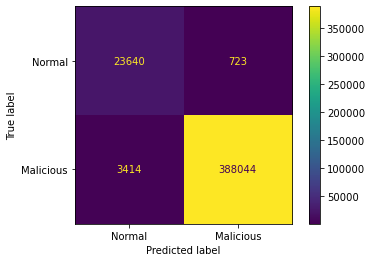

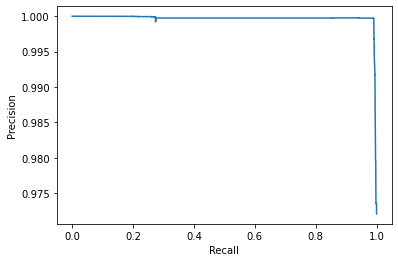

In [8]:
mcc_1 = metrics.matthews_corrcoef(true_class_1, model_class_1)
voi_1 = variation_of_information_score(true_class_1, model_class_1)
precision_1, recall_1, t = metrics.precision_recall_curve(true_class_1, -anomaly_scores_1)
prc_1 = metrics.PrecisionRecallDisplay(precision=precision_1, recall=recall_1)
default_precision_1 = metrics.precision_score(true_class_1, model_class_1)
default_recall_1 = metrics.recall_score(true_class_1, model_class_1)

print("MCC: ", mcc_1)
print("Variation of Information: ", voi_1)
print("Precision at default threshold: ", default_precision_1)
print("Recall at default threshold: ", default_recall_1)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_1, model_class_1, display_labels=["Normal", "Malicious"])

prc_1.plot()

This model scores well on both the MCC and Variation of Information scores. However, the precision-recall curve is completely useless. This is because there is far more malicious data than normal data - precision-recall curves work fine when the data are unbalanced in the *other* direction, but are worthless in this case.

Fortunately, we can simply run another test using the culled data set we used for training:

In [9]:
true_class_1_cull = np.array(train_data[train_data["test"] == 1].iloc[:, -2]) ^ True
anomaly_scores_1_cull = models[0].decision_function(train_data[train_data["test"] == 1].drop(columns = ["test", "normal"])) 
model_class_1_cull = anomaly_scores_1_cull < 0 # Doing this manually to avoid having to compute anomaly scores twice - since we need the actual scores for the curve

Precision at default threshold:  0.8425865447419987
Recall at default threshold:  0.989769820971867


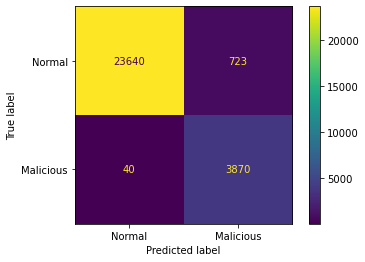

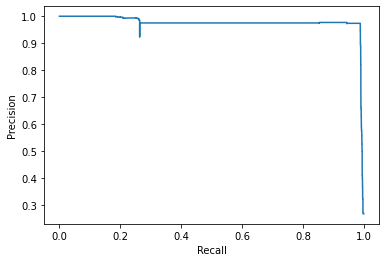

In [10]:
precision_1_cull, recall_1_cull, t = metrics.precision_recall_curve(true_class_1_cull, -anomaly_scores_1_cull)
prc_1_cull = metrics.PrecisionRecallDisplay(precision=precision_1_cull, recall=recall_1_cull)
default_precision_1_cull = metrics.precision_score(true_class_1_cull, model_class_1_cull)
default_recall_1_cull = metrics.recall_score(true_class_1_cull, model_class_1_cull)

print("Precision at default threshold: ", default_precision_1_cull)
print("Recall at default threshold: ", default_recall_1_cull)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_1_cull, model_class_1_cull, display_labels=["Normal", "Malicious"])

prc_1_cull.plot()

This precision-recall curve is much more useful, and we see that the model performs well under this measure as well. The structure of the curve is quite interesting - given the sharp drop in precision at around 0.25 recall (and the curve otherwise being very flat), it seems that there is a single cluster of normal data which gets picked up as anomalous at this threshold.

### Test class 2 (Remote to Local)

Again, we compute our metrics:

In [11]:
true_class_2 = np.array(data[data["test"] == 2].iloc[:, -2]) ^ True
anomaly_scores_2 = models[0].decision_function(data[data["test"] == 2].drop(columns = ["test", "normal"])) 
model_class_2 = anomaly_scores_2 < 0

MCC:  0.11433532655749007
Variation of Information:  0.3132366455671558
Precision at default threshold:  0.17343173431734318
Recall at default threshold:  0.12522202486678508


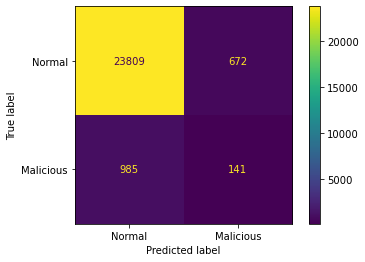

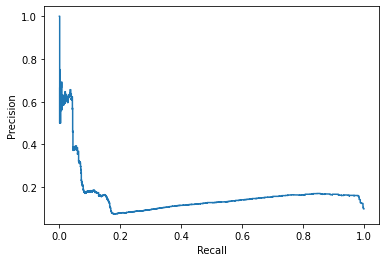

In [12]:
mcc_2 = metrics.matthews_corrcoef(true_class_2, model_class_2)
voi_2 = variation_of_information_score(true_class_2, model_class_2)
precision_2, recall_2, _ = metrics.precision_recall_curve(true_class_2, -anomaly_scores_2)
prc_2 = metrics.PrecisionRecallDisplay(precision=precision_2, recall=recall_2)
default_precision_2 = metrics.precision_score(true_class_2, model_class_2)
default_recall_2 = metrics.recall_score(true_class_2, model_class_2)

print("MCC: ", mcc_2)
print("Variation of Information: ", voi_2)
print("Precision at default threshold: ", default_precision_2)
print("Recall at default threshold: ", default_recall_2)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_2, model_class_2, display_labels=["Normal", "Malicious"])

prc_2.plot()

On *this* test class, we see that the model's performance is absolutely dismal. It performs better than a random classifier on all metrics, but not by much.

### Test class 3 (User to Root)

Computing metrics:

In [13]:
true_class_3 = np.array(data[data["test"] == 3].iloc[:, -2]) ^ True
anomaly_scores_3 = models[0].decision_function(data[data["test"] == 3].drop(columns = ["test", "normal"])) 
model_class_3 = anomaly_scores_3 < 0

MCC:  0.02930534520116697
Variation of Information:  0.14523301376597084
Precision at default threshold:  0.01
Recall at default threshold:  0.1346153846153846


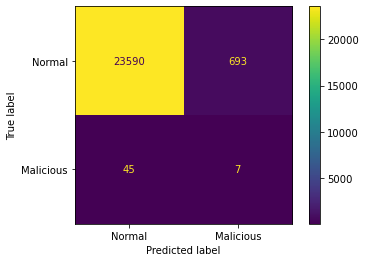

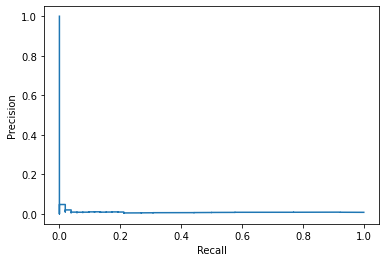

In [14]:
mcc_3 = metrics.matthews_corrcoef(true_class_3, model_class_3)
voi_3 = variation_of_information_score(true_class_3, model_class_3)
precision_3, recall_3, _ = metrics.precision_recall_curve(true_class_3, -anomaly_scores_3)
prc_3 = metrics.PrecisionRecallDisplay(precision=precision_3, recall=recall_3)
default_precision_3 = metrics.precision_score(true_class_3, model_class_3)
default_recall_3 = metrics.recall_score(true_class_3, model_class_3)

print("MCC: ", mcc_3)
print("Variation of Information: ", voi_3)
print("Precision at default threshold: ", default_precision_3)
print("Recall at default threshold: ", default_recall_3)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_3, model_class_3, display_labels=["Normal", "Malicious"])

prc_3.plot()

The performance on this test class is similarly bad as on test class 2 (although, there were very few malicious events of this type in the sample so it could plausibly be a sample size issue).

### Test class 4 (Probing)

Computing metrics:

In [15]:
true_class_4 = np.array(data[data["test"] == 4].iloc[:, -2]) ^ True
anomaly_scores_4 = models[0].decision_function(data[data["test"] == 4].drop(columns = ["test", "normal"])) 
model_class_4 = anomaly_scores_4 < 0

MCC:  0.8603879036125706
Variation of Information:  0.28215463428690446
Precision at default threshold:  0.8415446071904128
Recall at default threshold:  0.9233016800584368


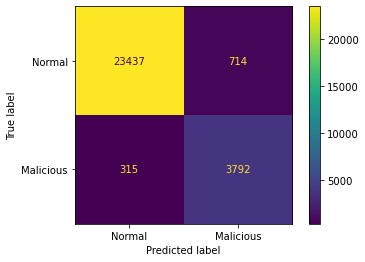

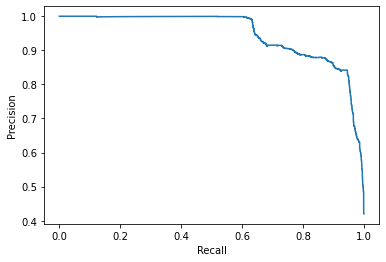

In [16]:
mcc_4 = metrics.matthews_corrcoef(true_class_4, model_class_4)
voi_4 = variation_of_information_score(true_class_4, model_class_4)
precision_4, recall_4, _ = metrics.precision_recall_curve(true_class_4, -anomaly_scores_4)
prc_4 = metrics.PrecisionRecallDisplay(precision=precision_4, recall=recall_4)
default_precision_4 = metrics.precision_score(true_class_4, model_class_4)
default_recall_4 = metrics.recall_score(true_class_4, model_class_4)

print("MCC: ", mcc_4)
print("Variation of Information: ", voi_4)
print("Precision at default threshold: ", default_precision_4)
print("Recall at default threshold: ", default_recall_4)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_4, model_class_4, display_labels=["Normal", "Malicious"])

prc_4.plot()

The model performs well on this test class, though not quite as well as it did on test class 1.

# Extended Isolation Forests

Though Isolation Forests have some nice properties (and we have already seen that they perform well in some cases), they also have a particular flaw: namely, the way in which the cuts are chosen.

Every time a partition is split, the cut is always along an axis. This introduces a sort of bias, which can obscure structure in the data or even create phantom clusters (see the referenced paper for some illustrative plots). This is remedied by allowing the cuts to be arbitrary hyperplanes - the resulting model is called an Extended Isolation Forest.

However - cutting along the axes is not always a bad thing! In particular, a lot of the features in our dataset are boolean - which means we often do want the cut hyperplanes to be parallel to these axes. Therefore, the Extended Isolation Forest model has an ExtensionLevel parameter. This determines the number of degrees of freedom to give the cuts - with an ExtensionLevel of $n$, the hyperplane is forced to be parallel to $d - n - 1$ axes, where $d$ is the number of features. Higher extension levels do not always give better results, so the first thing we must do is determine the optimal ExtensionLevel to use.

## Determining the ExtensionLevel

Ideally we would just train the model at each ExtensionLevel and see which is the best. Unfortunately, this is somewhat unfeasible - there are 118 possible ExtensionLevels, and the implementation of Extended Isolation Forests is much slower than sklearn's iForest implementation. So, we have to trim the data down significantly before we can do this - we use the culled data from earlier, and reserve 10% of it for testing. This shouldn't matter too much, since we won't actually be using these predictions.

Note: this code block will take quite a long time to run, and it's only used to determine the correct value of ExtensionLevel to be used later. I strongly suggest that you don't run it yourself!

In [ ]:
el_train, el_test = next(kf.split(train_data))
true_class = train_data.iloc[el_test].iloc[:, -2] ^ True
best_mcc = 0
for i in range(118):
    model = eif.iForest(np.array(train_data.iloc[el_train].drop(columns = ["test", "normal"])), ntrees=100, sample_size=256, ExtensionLevel=i)
    model_class = model.compute_paths(X_in=np.array(train_data.iloc[el_test].drop(columns = ["test", "normal"]))) > 0.5
    mcc = metrics.matthews_corrcoef(true_class, model_class)
    if mcc > best_mcc:
        best_mcc = mcc
        best_EL = i

In [22]:
best_EL

9

Since we got the best result with ExtensionLevel 9, this is what we will use going forwards. 

Note: this process is not properly reproducible - there is no way to seed the RNG for an EIF (at least with this implementation), and running the above blocks multiple times may give different results (I have got 6 and 7 before). I would like to use a more rigorous method to determine the correct level, but sadly this isn't feasible.

We now repeat the earlier training/testing, but with the EIF model instead.

## Training

We train the models using 10-fold cross-validiation within classes as before:

In [29]:
extended_models = []
for i in range(1,5):
    best_mcc = 0
    train_class = train_data[train_data["test"] != i]
    for split in kf.split(train_class):
        train = np.array(train_class.iloc[split[0]].drop(columns=["test", "normal"]))
        test = np.array(train_class.iloc[split[1]].drop(columns=["test", "normal"]))
        model = eif.iForest(train, ntrees=100, sample_size=256, ExtensionLevel=9)
        model_class = model.compute_paths(test) > 0.5
        true_class = np.array(train_class.iloc[split[1]].iloc[:, -2]) ^ True
        mcc = metrics.matthews_corrcoef(true_class, model_class)
        if mcc > best_mcc:
            best_mcc = mcc
            best_model = model
    extended_models.append(best_model)

## Evaluation

We use the same metrics for evaluation as in the ordinary iForest case:

### Test class 1 (Denial of Service)

In [31]:
extended_anomaly_scores_1 = extended_models[0].compute_paths(np.array(data[data["test"] == 1].drop(columns = ["test", "normal"])))

In [32]:
extended_model_class_1 = extended_anomaly_scores_1 > 0.5

MCC:  0.9341784868720493
Variation of Information:  0.07269881813699997
Precision at default threshold:  0.9995855909190358
Recall at default threshold:  0.9920451236147939


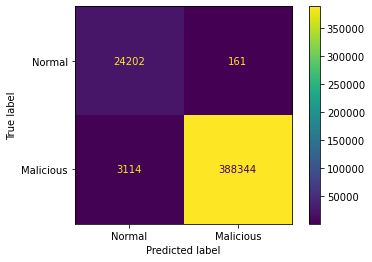

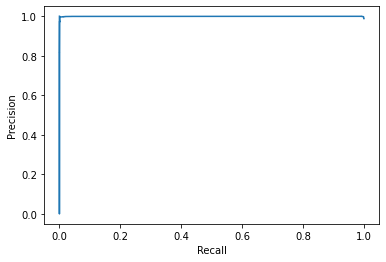

In [34]:
ex_mcc_1 = metrics.matthews_corrcoef(true_class_1, extended_model_class_1)
ex_voi_1 = variation_of_information_score(true_class_1, extended_model_class_1)
ex_precision_1, ex_recall_1, t = metrics.precision_recall_curve(true_class_1, extended_anomaly_scores_1) # The anomaly scores are not negative this time, since EIF does not negate them
ex_prc_1 = metrics.PrecisionRecallDisplay(precision=ex_precision_1, recall=ex_recall_1)
ex_default_precision_1 = metrics.precision_score(true_class_1, extended_model_class_1)
ex_default_recall_1 = metrics.recall_score(true_class_1, extended_model_class_1)

print("MCC: ", ex_mcc_1)
print("Variation of Information: ", ex_voi_1)
print("Precision at default threshold: ", ex_default_precision_1)
print("Recall at default threshold: ", ex_default_recall_1)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_1, extended_model_class_1, display_labels=["Normal", "Malicious"])

ex_prc_1.plot()

We can see that this Extended Isolation Forest performs better than the ordinary iForest on every metric. Like before, the precision-recall curve is useless - and we will remedy this in the same way by considering the culled dataset:

In [35]:
extended_anomaly_scores_1_cull = extended_models[0].compute_paths(np.array(train_data[train_data["test"] == 1].drop(columns = ["test", "normal"])))

In [58]:
extended_model_class_1_cull = extended_anomaly_scores_1_cull > 0.5

Precision at default threshold:  0.9601189001733961
Recall at default threshold:  0.991304347826087


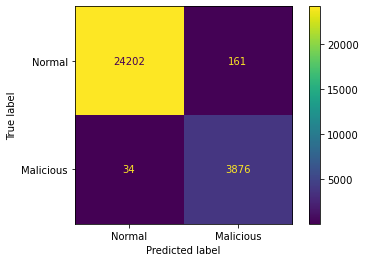

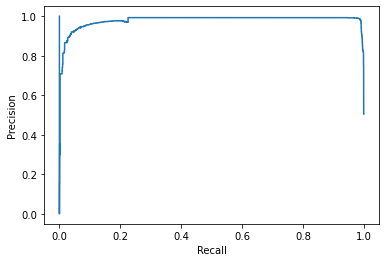

In [59]:
ex_precision_1_c, ex_recall_1_c, t = metrics.precision_recall_curve(true_class_1_cull, extended_anomaly_scores_1_cull) # The anomaly scores are not negative this time, since EIF does not negate them
ex_prc_1_c = metrics.PrecisionRecallDisplay(precision=ex_precision_1_c, recall=ex_recall_1_c)
ex_default_precision_1_c = metrics.precision_score(true_class_1_cull, extended_model_class_1_cull)
ex_default_recall_1_c = metrics.recall_score(true_class_1_cull, extended_model_class_1_cull)

print("Precision at default threshold: ", ex_default_precision_1_c)
print("Recall at default threshold: ", ex_default_recall_1_c)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_1_cull, extended_model_class_1_cull, display_labels=["Normal", "Malicious"])

ex_prc_1_c.plot()

### Test class 2 (Remote to Local)

In [63]:
extended_anomaly_scores_2 = extended_models[1].compute_paths(np.array(data[data["test"] == 2].drop(columns = ["test", "normal"])))

In [64]:
extended_model_class_2 = extended_anomaly_scores_2 > 0.5

MCC:  0.2509465144887545
Variation of Information:  0.2352068471182166
Precision at default threshold:  0.45663265306122447
Recall at default threshold:  0.15896980461811722


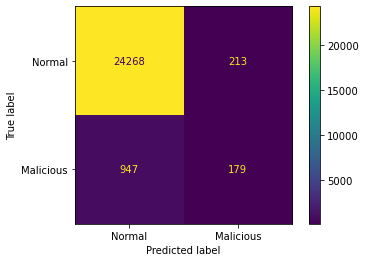

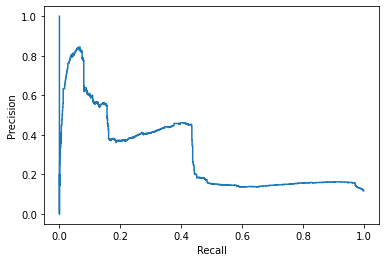

In [65]:
ex_mcc_2 = metrics.matthews_corrcoef(true_class_2, extended_model_class_2)
ex_voi_2 = variation_of_information_score(true_class_2, extended_model_class_2)
ex_precision_2, ex_recall_2, t = metrics.precision_recall_curve(true_class_2, extended_anomaly_scores_2)
ex_prc_2 = metrics.PrecisionRecallDisplay(precision=ex_precision_2, recall=ex_recall_2)
ex_default_precision_2 = metrics.precision_score(true_class_2, extended_model_class_2)
ex_default_recall_2 = metrics.recall_score(true_class_2, extended_model_class_2)

print("MCC: ", ex_mcc_2)
print("Variation of Information: ", ex_voi_2)
print("Precision at default threshold: ", ex_default_precision_2)
print("Recall at default threshold: ", ex_default_recall_2)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_2, extended_model_class_2, display_labels=["Normal", "Malicious"])

ex_prc_2.plot()

The performance here is noticably better than that of the ordinary isolation forest on all metrics. However, it is still by no means good - getting any semblance of reliable precision requires dropping the recall to under 0.1.

### Test class 3 (User to Root)

In [66]:
extended_anomaly_scores_3 = extended_models[2].compute_paths(np.array(data[data["test"] == 3].drop(columns = ["test", "normal"])))

In [67]:
extended_model_class_3 = extended_anomaly_scores_3 > 0.5

MCC:  0.2164596440878482
Variation of Information:  0.04932827227644411
Precision at default threshold:  0.125
Recall at default threshold:  0.38461538461538464


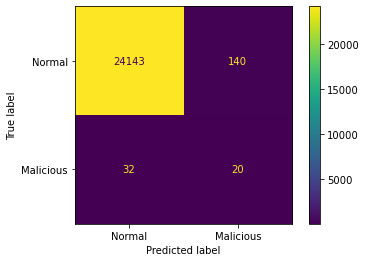

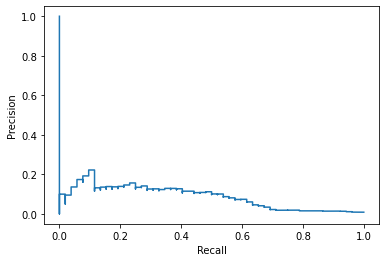

In [ ]:
ex_mcc_3 = metrics.matthews_corrcoef(true_class_3, extended_model_class_3)
ex_voi_3 = variation_of_information_score(true_class_3, extended_model_class_3)
ex_precision_3, ex_recall_3, t = metrics.precision_recall_curve(true_class_3, extended_anomaly_scores_3)
ex_prc_3 = metrics.PrecisionRecallDisplay(precision=ex_precision_3, recall=ex_recall_3)
ex_default_precision_3 = metrics.precision_score(true_class_3, extended_model_class_3)
ex_default_recall_3 = metrics.recall_score(true_class_3, extended_model_class_3)

print("MCC: ", ex_mcc_3)
print("Variation of Information: ", ex_voi_3)
print("Precision at default threshold: ", ex_default_precision_3)
print("Recall at default threshold: ", ex_default_recall_3)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_3, extended_model_class_3, display_labels=["Normal", "Malicious"])

ex_prc_3.plot()

Much like with test class 2, the extended isolation forest performs significantly better than previously. However, it is still not good enough to be actually useful.

One thing which may seem strange here is that the variation of information score appears low, despite the poor performance. This is because there are very few malicious data points (real or predicted) here, so both classifications are close to constant and therefore have low entropy (they carry little information).

### Test class 4 (Probing)

In [69]:
extended_anomaly_scores_4 = extended_models[3].compute_paths(np.array(data[data["test"] == 4].drop(columns = ["test", "normal"])))

In [70]:
extended_model_class_4 = extended_anomaly_scores_4 > 0.5

MCC:  0.7036347208050477
Variation of Information:  0.3823150288461738
Precision at default threshold:  0.930886372510738
Recall at default threshold:  0.580472364256148


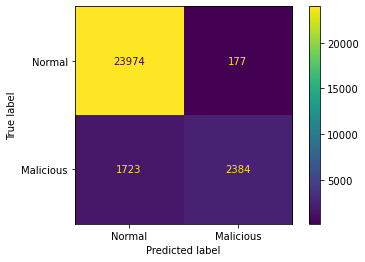

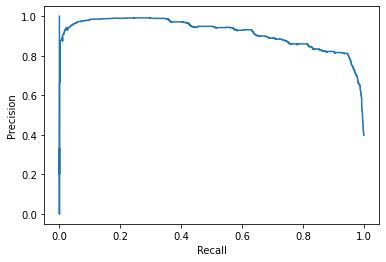

In [71]:
ex_mcc_4 = metrics.matthews_corrcoef(true_class_4, extended_model_class_4)
ex_voi_4 = variation_of_information_score(true_class_4, extended_model_class_4)
ex_precision_4, ex_recall_4, t = metrics.precision_recall_curve(true_class_4, extended_anomaly_scores_4)
ex_prc_4 = metrics.PrecisionRecallDisplay(precision=ex_precision_4, recall=ex_recall_4)
ex_default_precision_4 = metrics.precision_score(true_class_4, extended_model_class_4)
ex_default_recall_4 = metrics.recall_score(true_class_4, extended_model_class_4)

print("MCC: ", ex_mcc_4)
print("Variation of Information: ", ex_voi_4)
print("Precision at default threshold: ", ex_default_precision_4)
print("Recall at default threshold: ", ex_default_recall_4)
metrics.ConfusionMatrixDisplay.from_predictions(true_class_4, extended_model_class_4, display_labels=["Normal", "Malicious"])

ex_prc_4.plot()

Unlike in the previous cases, this time we actually see the extended isolation forest perform *worse* than the original version! This is somewhat surprising - the most likely explanation is probably that restricting the cuts to be along the axes happened to take advantage of some feature of the anomalies in this case (so it made them *easier* to isolate quickly).

# Conclusion

The Isolation Forest classifier had somewhat mixed performance - it was excellent on test class 1 and good on test class 4, but it was essentially useless on test classes 2 and 3. This indicates that it may be suitable if you are looking for a particular type of attack, but that you should not expect it to work well in every case.

Extended Isolation Forests performed better than the ordinary version in most cases (test classes 1, 2, and 3). However, the performance improvement on test classes 2 and 3 was not enough to salvage them, and the performance on class 4 was actually *worse*. Given that it also takes much longer to run than the ordinary version (at least in this implementation), it is not clear whether the performance gain is worthwhile.

## References
### Original papers on Isolation Forests:
[Liu, Fei Tony & Ting, Kai & Zhou, Zhi-Hua. (2009). Isolation Forest. 413 - 422. 10.1109/ICDM.2008.17.](https://www.researchgate.net/publication/224384174_Isolation_Forest)  
[Liu, Fei Tony & Ting, Kai & Zhou, Zhi-Hua. (2012). Isolation-Based Anomaly Detection. ACM Transactions on Knowledge Discovery From Data - TKDD. 6. 1-39. 10.1145/2133360.2133363. ](https://www.researchgate.net/publication/239761771_Isolation-Based_Anomaly_Detection)
### Extended Isolation Forests
[S. Hariri, M. C. Kind and R. J. Brunner, "Extended Isolation Forest," in IEEE Transactions on Knowledge and Data Engineering, vol. 33, no. 4, pp. 1479-1489, 1 April 2021, doi: 10.1109/TKDE.2019.2947676.](https://ieeexplore.ieee.org/document/8888179)
Implementation at https://pypi.org/project/eif/